# **Read the Data**

In [1]:
import numpy as np
import copy
import os
import xarray as xr
from datetime import datetime
from datetime import timedelta
import pandas as pd
from shapely.geometry import Polygon, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# nice figures
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

input_file_data="./ERA_1degree_Daily_2000-2020_allvars2.nc"
input_file_labels="./discharge_lobith_daily.xlsx"

def read_data(input_file_data,input_file_labels):
    
    start_date=datetime(2000,1,1)
    end_date=datetime(2021,1,1)
    
    ds = xr.open_dataset(input_file_data)
    labels=pd.read_excel(input_file_labels)
    #align labels and input data in the time dimension
    labels=labels[np.logical_and(labels['datetime']>=start_date,labels['datetime']<end_date)]
    labels=np.array(labels['Q'])
    
    return ds,labels

#load input data and corresponding labels with daily resolution (t,lat,lon)
#variable names: tp-> total precipitation t2m-> 2 meters temperature swvl1 -> Volumetric soil water layer 1
data,labels=read_data(input_file_data,input_file_labels)

#eliminate first longitude which contains nans
data=data.sel(latitude=slice(46.0, 53.0), longitude=slice(4, 12))

#time_line of the data in datetime format
time_line=np.array([datetime.utcfromtimestamp(date.astype('datetime64[s]').astype('int')) for date in np.array(data['time'])])

print(time_line.shape)
print(labels.shape)

(7671,)
(7671,)


In [2]:
data

<xarray.Dataset>
Dimensions:    (time: 7671, latitude: 8, longitude: 9)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * latitude   (latitude) float64 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0
  * longitude  (longitude) int32 4 5 6 7 8 9 10 11 12
Data variables:
    tp         (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
    swvl1      (time, latitude, longitude) float64 ...
    lai_hv     (time, latitude, longitude) float64 ...
    lai_lv     (time, latitude, longitude) float64 ...
    pev        (time, latitude, longitude) float64 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

# **Plot January Mean**

In [3]:
#function to select all the samples in January 2020 (for the 3 variables tp,t2m,swl1) given in input 
#the era5 dataset and the timeline. The function returns the data in numpy format for the 3 variables separately

def select_January_data(data,time_line):

    tidx = np.where((time_line >= datetime(2020,1,1,0,0)) & (time_line <= datetime(2020,1,31,0,0)))[0]
    tp_January = data['tp'][tidx]
    t2m_January = data['t2m'][tidx]
    swvl1_January = data['swvl1'][tidx]
    
    return tp_January,t2m_January,swvl1_January

#function to plot the Jan 2020 mean given in input the dataset and the time_line
# def plot_monthly_mean(data,time_line):
def plot_monthly_mean(var,tt,clabel,vn,vm,cmp=plt.cm.jet):
    
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_global()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines(lw=0.5)
    
    # lat = var['latitude']
    # lon = var['longitude']
    lat = np.arange(46,53+1)
    lon = np.arange(4,12+1)
    x_extent = lon
    y_extent = lat
    ax.set_xticks(x_extent,crs=ccrs.PlateCarree())
    ax.set_yticks(y_extent,crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    # Convert lat/lon to map coordinates
    Lon, Lat = np.meshgrid(lon, lat)

    pm = ax.pcolormesh(Lon, Lat, np.mean(var,axis=0), cmap=cmp, vmin=vn, vmax=vm)

    # Add a colorbar
    cb = plt.colorbar(pm, label=r"%s"%clabel, orientation="vertical")
    
    ax.set_title(r"%s"%tt)
    ax.set_aspect('auto')
    plt.savefig("figs/%s"%tt, bbox_inches='tight')

    return
    

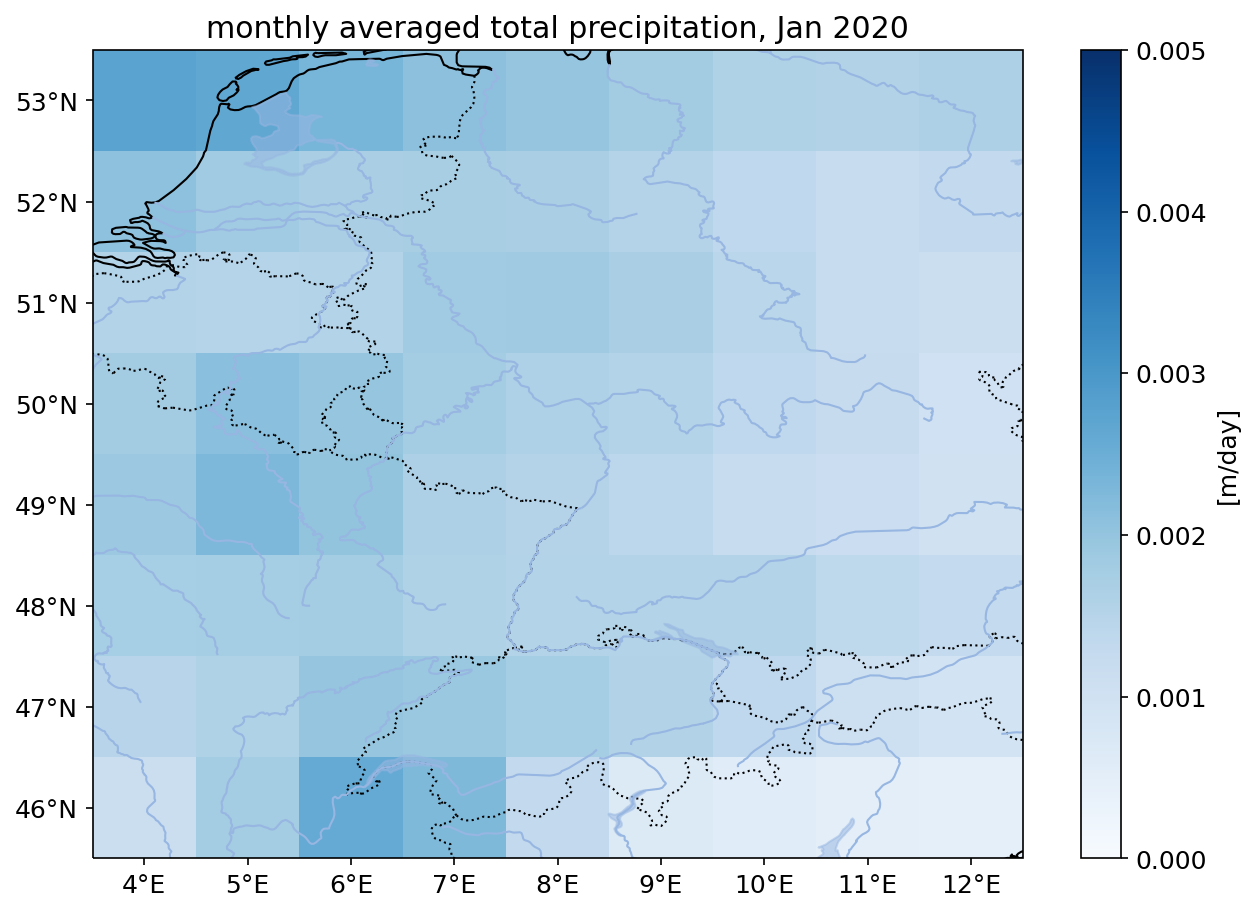

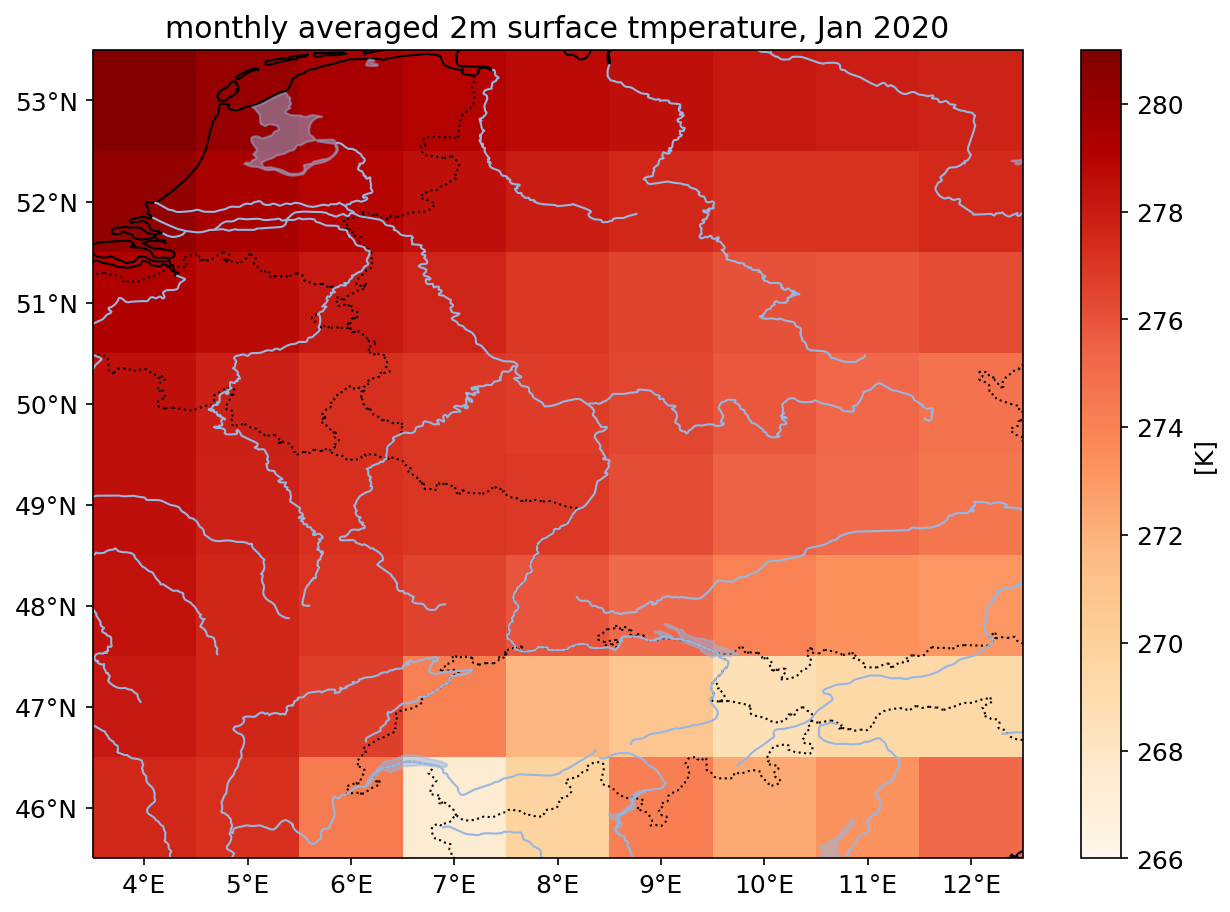

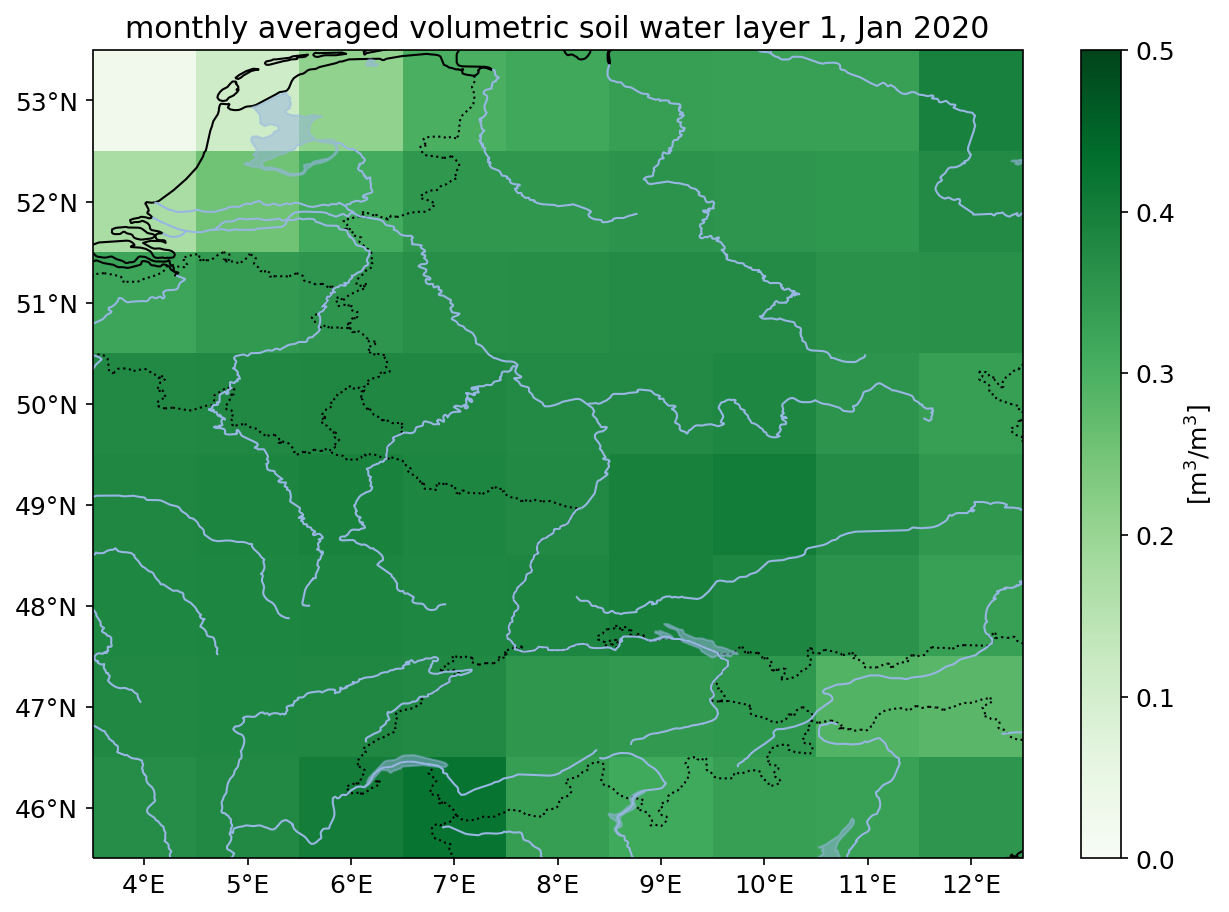

In [4]:
tp_January,t2m_January,swvl1_January = select_January_data(data, time_line)
plot_monthly_mean(tp_January,'monthly averaged total precipitation, Jan 2020','[m/day]',vn=0,vm=5e-3,cmp=plt.cm.Blues)
plot_monthly_mean(t2m_January,'monthly averaged 2m surface tmperature, Jan 2020','[K]',vn=266,vm=281,cmp=plt.cm.OrRd)
plot_monthly_mean(swvl1_January,'monthly averaged volumetric soil water layer 1, Jan 2020','[m$^3$/m$^3$]',vn=0,vm=0.5,cmp=plt.cm.Greens)

# **Determine Time Delay**

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


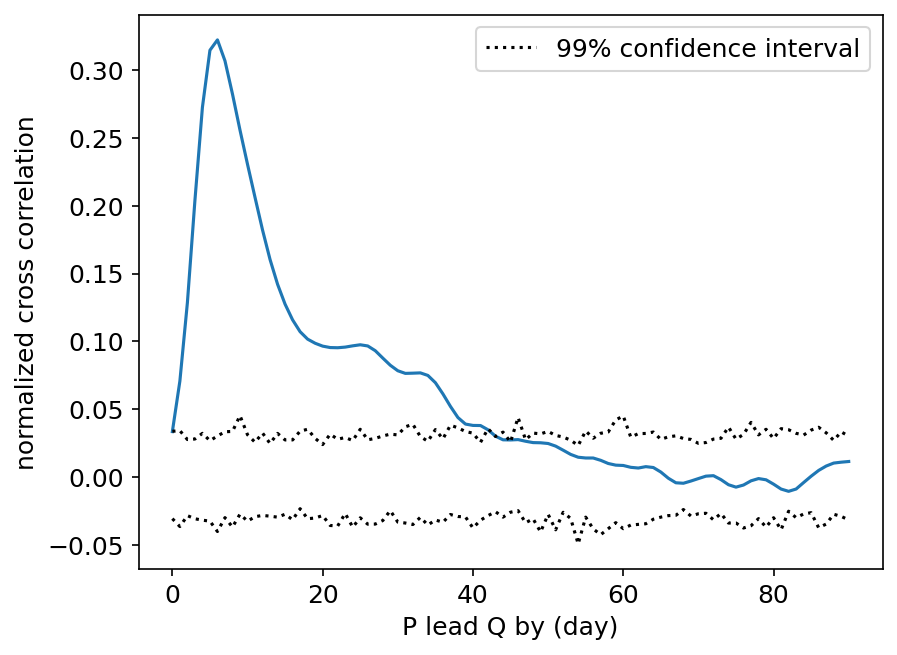

In [6]:
#determine lagged correlation
#function to compute the region average of precipition P and the lagged correlation between the region average 
#and the corresponding discharge values given in input the ERA5 dataset, the river discharge and the lag. 
#This function can be used to compute the correlation for different lags to then plot the results

import scipy.signal as spsg

def xcorr(x,y):
    # similar to xcorr in matlab
    # normalization
    x_nm = (x-np.mean(x,0))/np.std(x,0)
    y_nm = (y-np.mean(y,0))/np.std(y,0)
    xlen = x_nm.shape[0]
    ylen = y_nm.shape[0]
    nm = np.sqrt( (xlen*1*1) * (ylen*1*1) )

    corr = spsg.correlate(x_nm, y_nm, mode="full")/nm
    lags = spsg.correlation_lags(xlen, ylen, mode="full")
    tidx = np.where((lags >= 0) & (lags <= 90))[0]
    return lags[tidx], corr[tidx], x_nm, y_nm

Q = labels
P_ra = np.mean(data['tp'],axis=(1,2))
lags, corr, Q_nm, P_ra_nm = xcorr(Q,P_ra)
plt.figure()
plt.plot(lags,corr)
print(lags[np.where(corr>=0.11)[0]])

rpnum = 199 # for two-sided 99% ci, see original reference paper 
corr_s_arr = np.zeros((rpnum,91))
for i in range(rpnum):
    Q_nm_s = copy.deepcopy(Q_nm)
    np.random.shuffle(Q_nm_s)
    lags, corr, tmp1, tmp2  = xcorr(Q_nm_s,P_ra_nm)
    corr_s_arr[i,:] = corr
corr_s_max = np.max(corr_s_arr,0)
corr_s_min = np.min(corr_s_arr,0)
plt.plot(lags,corr_s_max,':k',label='99% confidence interval')
plt.plot(lags,corr_s_min,':k')

plt.xlabel('P lead Q by (day)')
plt.ylabel('normalized cross correlation')
plt.legend()
plt.savefig("figs/xcorr", bbox_inches='tight')

# ci99: 1~40

# **Preprocessing functions**

In [7]:
#function to select variables from the ERA5 dataset, given in input the dataset and a list containing 
#variables names, the function return the data in numpy format
from functools import reduce

def prepare_data(data,variables):
    X = np.zeros((len(variables), 7671, 8, 9))
    for i in range(len(variables)):
        X[i,:,:,:] = data[variables[i]]
        
    return X

#function to split data in train/test given in input the data in numpy with corresponding labels and time_line.
#Return training set, validation set, training labels, validation labels, training timeline and 
#validation timeline
def train_test_split(X,labels,time_line):
    train_tidx = np.where(time_line <= datetime(2016,12,31,0,0))[0]
    val_tidx = np.where(time_line >= datetime(2017,1,1,0,0))[0]
    X_train = X[:,train_tidx,:,:]
    X_validation = X[:,val_tidx,:,:]
    y_train = labels[train_tidx]
    y_validation = labels[val_tidx]
    time_line_train = time_line[train_tidx]
    time_line_validation = time_line[val_tidx]
    
    return X_train,X_validation,y_train,y_validation,time_line_train,time_line_validation

#function to normalize data based on training data mean and std given in input the dataset we want to use 
#to compute mean and std (X_mean_std) and the data we want to normalize (X)
def normalize_data(X_ref,X):
    # X_ref: train; X: train/test
    X_mean = np.mean(X_ref,axis=1).reshape((X.shape[0],1,8,9))
    X_std = np.std(X_ref,axis=1).reshape((X.shape[0],1,8,9))
    X_normalized = ( X-X_mean ) / X_std
    return X_normalized, X_mean, X_std

#function to normalize the labels (discharge) based on training data labels, given in input labels to use to 
#compute mean and std (labels_mean_std) and the labels to normalize (labels).
#Return normalized labels and mean and std to reverse normalization
def normalize_labels(labels_ref,labels):
    # labels_ref: train; labels: train/test
    train_mean = np.mean(labels_ref)
    train_std = np.std(labels_ref)
    labels_normalized = ( labels-train_mean ) / train_std
    return labels_normalized,train_mean,train_std
    
#function to define our samples for training using a rolling time window of dimension t. The dimension of each 
#sample, must be [t,lat,lon,variables] if you use tensorflow, [variables,t,lat,lon] if you use pytorch.
#In input the data we want to transform in numpy format with the corresponding labels and the dimension of 
#the time window. Return transformed samples and corresponding labels aligned in time with new data
def prepare_running_window_samples(X,labels,window_dimension):
    dt = window_dimension[-1]
    winlen = window_dimension.shape[0]
    labels_aligned = labels[dt:]
    samplelen = labels_aligned.shape[0]
    running_dataset = np.zeros((samplelen,X.shape[0],winlen,8,9))
    for i in range(samplelen):
        running_dataset[i,:,:,:,:] = X[:,dt-window_dimension+i,:,:]
    return running_dataset,labels_aligned

#function to select the winter and summer period data from the validation data, given in input the validation data
#in numpy format, the validation labels and the validation data time_line. Return the Validation data corresponding
#to summer and winter with corresponding labels
def select_summer_winter_period(X,labels,time_line):
    # timeline:d0~, labels:d0~, X:(d-40~d-1)~
    tidx_djf2017 = np.where( (time_line >= datetime(2017,1,1,0,0)) & (time_line <= datetime(2017,2,28,0,0)) )[0]
    tidx_djf2018 = np.where( (time_line >= datetime(2017,12,1,0,0)) & (time_line <= datetime(2018,2,28,0,0)) )[0]
    tidx_djf2019 = np.where( (time_line >= datetime(2018,12,1,0,0)) & (time_line <= datetime(2019,2,28,0,0)) )[0]
    tidx_djf2020 = np.where( (time_line >= datetime(2019,12,1,0,0)) & (time_line <= datetime(2020,2,29,0,0)) )[0]
    tidx_djf2021 = np.where( (time_line >= datetime(2020,12,1,0,0)) & (time_line <= datetime(2020,12,31,0,0)) )[0]
    tidx_djf = reduce(np.union1d, (tidx_djf2017,tidx_djf2018,tidx_djf2019,tidx_djf2020,tidx_djf2021))
    tidx_jja2017 = np.where( (time_line >= datetime(2017,6,1,0,0)) & (time_line <= datetime(2017,8,31,0,0)) )[0]
    tidx_jja2018 = np.where( (time_line >= datetime(2018,6,1,0,0)) & (time_line <= datetime(2018,8,31,0,0)) )[0]
    tidx_jja2019 = np.where( (time_line >= datetime(2019,6,1,0,0)) & (time_line <= datetime(2019,8,31,0,0)) )[0]
    tidx_jja2020 = np.where( (time_line >= datetime(2020,6,1,0,0)) & (time_line <= datetime(2020,8,31,0,0)) )[0]
    tidx_jja = reduce(np.union1d, (tidx_jja2017,tidx_jja2018,tidx_jja2019,tidx_jja2020))
    # print(time_line[tidx_djf])
    # print(time_line[tidx_jja])
    X_jja = X[tidx_jja,:,:,:,:]
    X_djf = X[tidx_djf,:,:,:,:]
    labels_jja = labels[tidx_jja]
    labels_djf = labels[tidx_djf]
    
    return X_jja,X_djf,labels_jja,labels_djf
        
    
variables = ['tp','t2m','swvl1'] #list of variables names
# variables = ['tp','t2m']
t = np.arange(1,41) #define time window dimension: 1~40 days ahead
# t = np.arange(2,17) #2~16
wlen = t.shape[0]
X = prepare_data(data,variables)
print(wlen)

X_train,X_validation,labels_train,labels_validation,time_line_train,time_line_validation=train_test_split(X,labels,time_line)
print(X_train.shape,X_validation.shape,labels_train.shape,labels_validation.shape)

labels_train_scaled,mean_labels,std_labels=normalize_labels(labels_train,labels_train)
print(labels_train_scaled.shape)

X_train_normalized, X_ref_mean, X_ref_std=normalize_data(X_train,X_train)
X_validation_normalized, X_ref_mean, X_ref_std=normalize_data(X_train,X_validation)
print(X_train_normalized.shape)
print(X_validation_normalized.shape)

X_train_normalized_sliced,labels_train_sliced=prepare_running_window_samples(X_train_normalized,labels_train_scaled,t)
X_validation_normalized_sliced,labels_validation_sliced=prepare_running_window_samples(X_validation_normalized,labels_validation,t)
# with lags in generating samples removed
time_line_train_ = time_line_train[t[-1]:]
time_line_validation_ = time_line_validation[t[-1]:]

print(X_train_normalized_sliced.shape)
print(X_validation_normalized_sliced.shape)
print(labels_train_sliced.shape)
print(labels_validation_sliced.shape)

# same as val: normalized X, raw label
X_jja,X_djf,labels_jja,labels_djf = select_summer_winter_period(X_validation_normalized_sliced,labels_validation_sliced,time_line_validation_)
print(X_jja.shape)
print(X_djf.shape)
print(labels_jja.shape)
print(labels_djf.shape)

40
(3, 6210, 8, 9) (3, 1461, 8, 9) (6210,) (1461,)
(6210,)
(3, 6210, 8, 9)
(3, 1461, 8, 9)
(6170, 3, 40, 8, 9)
(1421, 3, 40, 8, 9)
(6170,)
(1421,)
(368, 3, 40, 8, 9)
(321, 3, 40, 8, 9)
(368,)
(321,)


# **Definition of Pytorch functions**

In [8]:
import torch
#define initial hyper-parameters and device gpu. On mac is mps, change it for windows
# set random seed
random_seed = 2024
torch.manual_seed(int(random_seed))
np.random.seed(int(random_seed))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size=10
lr=1e-4
n_epochs=20

In [9]:
from torch.utils.data import Dataset, DataLoader

#define your custom dataset 
class CustomDataset(Dataset):

    def __init__(self, X, labels):
        self.data=X
        self.labels=labels

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx):
        # [sampleidx, v,t,lat,lon]
        return self.data[idx,:,:,:,:],self.labels[idx]


In [10]:
#define the network
import torch
import torch.nn as nn

#you need to define a network with 2 Conv3d layers, each one with 16 output channels, kernel_size=3 and padding=1.
#After each Conv3d layer ReLU activation function. After the 2 Conv3d layer a MaxPool3d layer with kernel size
#(2,1,1) and stride (2,1,1) (perform maxpooling only in time direction). After pooling flatten the data then
#MLP (Multy layer perceptron) with 3 hidden layers with n_neurons 256, 128 and 64. Relu after each hidden layer.
#Output layer with dimension one and linear activation function.

class Conv3DNet(nn.Module):
    def __init__(self,flatten_dim,in_channels=1):
        super(Conv3DNet, self).__init__()
        # input dim0(var) collapse into 1
        self.conv1 = nn.Sequential(         
            nn.Conv3d(
                in_channels,              
                out_channels=16,            
                kernel_size=3,                                 
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool3d(
                kernel_size=(2,1,1),
                stride=(2,1,1)
            ),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv3d(
                in_channels=16,              
                out_channels=16,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            nn.ReLU(),                      
            nn.MaxPool3d(
                kernel_size=(2,1,1),
                stride=(2,1,1)
            ),         
        )
        self.nn1 = nn.Sequential(
            nn.Linear(flatten_dim,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )      
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, input_dimensions)
        x = x.view(x.size(0), -1)
        # print(x.size())
        output = self.nn1(x)
        return output

In [11]:
int(16*(40/2/2)*8*9)

11520

In [12]:
import torch.nn as nn
#function to train your model. Define the train loop and save after each epoch the mse with respect to normalized
#labels and mean absolute error with respect to original labels (reverse transformation). In input 
#training data in numpy format, training dataloader, learning rate and number of epochs.
#Returned trained model, a list containing loss per epoch and a list containing mae per epoch

def train(labels_nm,dataloader,lr,n_epochs,wlen):
    # reminder
    print(variables)
    #define loss function and optimizer 
    samplelen = labels_nm.shape[0]
    
    model = Conv3DNet(flatten_dim=int(16*int(int(wlen/2)/2)*8*9),in_channels=len(variables))
    optimizer = torch.optim.Adam(model.parameters(),lr,weight_decay=0)
    lossfunc = nn.MSELoss()
    maefunc = nn.L1Loss()
    
    loss_epochs = np.zeros(n_epochs)
    mae_epochs = np.zeros(n_epochs)
    #define the training loop remember to save loss and mae at each epoch in the correct way
    for epoch in range(n_epochs):
        print("epoch:{}".format(epoch))
        losssum_current_epoch = 0
        maesum_current_epoch = 0

        for i, datapack in enumerate(dataloader):
            # Iterate over the batches and save loss and mae to then compute loss and mae per epoch
            #to implement
            data_inputs = datapack[0]
            data_labels = datapack[1].float()
            preds = model(data_inputs).squeeze()
            
            loss = lossfunc(preds,data_labels)
            losssum_current_epoch += loss*batch_size
            maesum_current_epoch += maefunc(preds*std_labels+mean_labels,data_labels*std_labels+mean_labels)*batch_size
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()
            
        loss_epochs[epoch] = losssum_current_epoch/samplelen
        mae_epochs[epoch] = maesum_current_epoch/samplelen
        print("loss epoch:{} is:{}".format(epoch,loss_epochs[epoch]))
        print("mae epoch:{} is:{}".format(epoch,mae_epochs[epoch]))
            
    return model,loss_epochs,mae_epochs

    
#convert training data to tensors
X_train_torch=torch.from_numpy(X_train_normalized_sliced).float()
labels_train_torch=torch.from_numpy(labels_train_sliced).float()

#define custom dataset using training data
dataset=CustomDataset(X_train_torch,labels_train_torch)
#define dataloader using the custom dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# test for input_dim for nn1
# for i,data in enumerate(dataloader):
#     model = Conv3DNet(in_channels=3)
#     preds = model(data[0])

model_tpv,loss_epochs_tpv,mae_epochs_tpv = train(labels_train_torch,dataloader,lr,n_epochs,wlen)
# model_tp,loss_epochs_tp,mae_epochs_tp = train(labels_train_torch,dataloader,lr,n_epochs,wlen)
# model_tpv16,loss_epochs_tpv16,mae_epochs_tpv16 = train(labels_train_torch,dataloader,lr,n_epochs,wlen)

['tp', 't2m', 'swvl1']
epoch:0
loss epoch:0 is:0.7041038870811462
mae epoch:0 is:620.9705200195312
epoch:1
loss epoch:1 is:0.400656521320343
mae epoch:1 is:471.7396240234375
epoch:2
loss epoch:2 is:0.29151451587677
mae epoch:2 is:396.9911804199219
epoch:3
loss epoch:3 is:0.21304138004779816
mae epoch:3 is:347.68853759765625
epoch:4
loss epoch:4 is:0.18187196552753448
mae epoch:4 is:321.6018371582031
epoch:5
loss epoch:5 is:0.15370163321495056
mae epoch:5 is:300.8629150390625
epoch:6
loss epoch:6 is:0.1474202275276184
mae epoch:6 is:292.36151123046875
epoch:7
loss epoch:7 is:0.1444772481918335
mae epoch:7 is:286.2493591308594
epoch:8
loss epoch:8 is:0.12965188920497894
mae epoch:8 is:275.2584533691406
epoch:9
loss epoch:9 is:0.1116717979311943
mae epoch:9 is:263.1297302246094
epoch:10
loss epoch:10 is:0.12313345074653625
mae epoch:10 is:275.26568603515625
epoch:11
loss epoch:11 is:0.08534834533929825
mae epoch:11 is:234.29808044433594
epoch:12
loss epoch:12 is:0.10654561221599579
mae ep

# **Loss and MAE during training** 

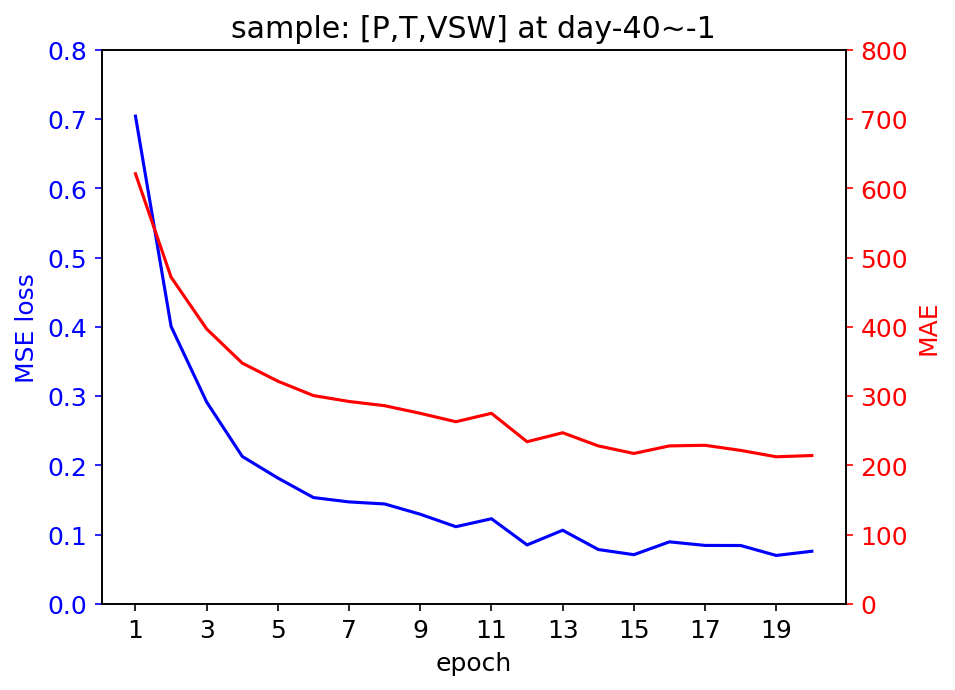

In [189]:
def plt_d(loss_epochs,mae_epochs,tt,fname):
    tidc = np.arange(1,n_epochs+1)
    fig, ax1 = plt.subplots()

    ax1.plot(tidc, loss_epochs,'-b')
    ax1.set_xlabel('epoch')
    ax1.set_xticks(np.arange(-1,21,2))
    ax1.set_ylim(0,0.8)
    ax1.set_ylabel('MSE loss',color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(tidc, mae_epochs,'-r')
    ax2.set_ylim(0,800)
    ax2.set_ylabel('MAE',color='r')
    ax2.tick_params('y', colors='r')
    
    plt.title('sample: {}'.format(tt))
    plt.savefig("figs/%s_d"%fname, bbox_inches='tight')
    
    return

plt_d(loss_epochs_tpv,mae_epochs_tpv,'[P,T,VSW] at day-40~-1','tpv40')
# plt_d(loss_epochs_tp,mae_epochs_tp,'[P,T] at day-40~-1','tp40')
# plt_d(loss_epochs_tpv16,mae_epochs_tpv16,'[P,T,VSW] at day-16~-2','tpv16')

# **MAE and performance on validation** 

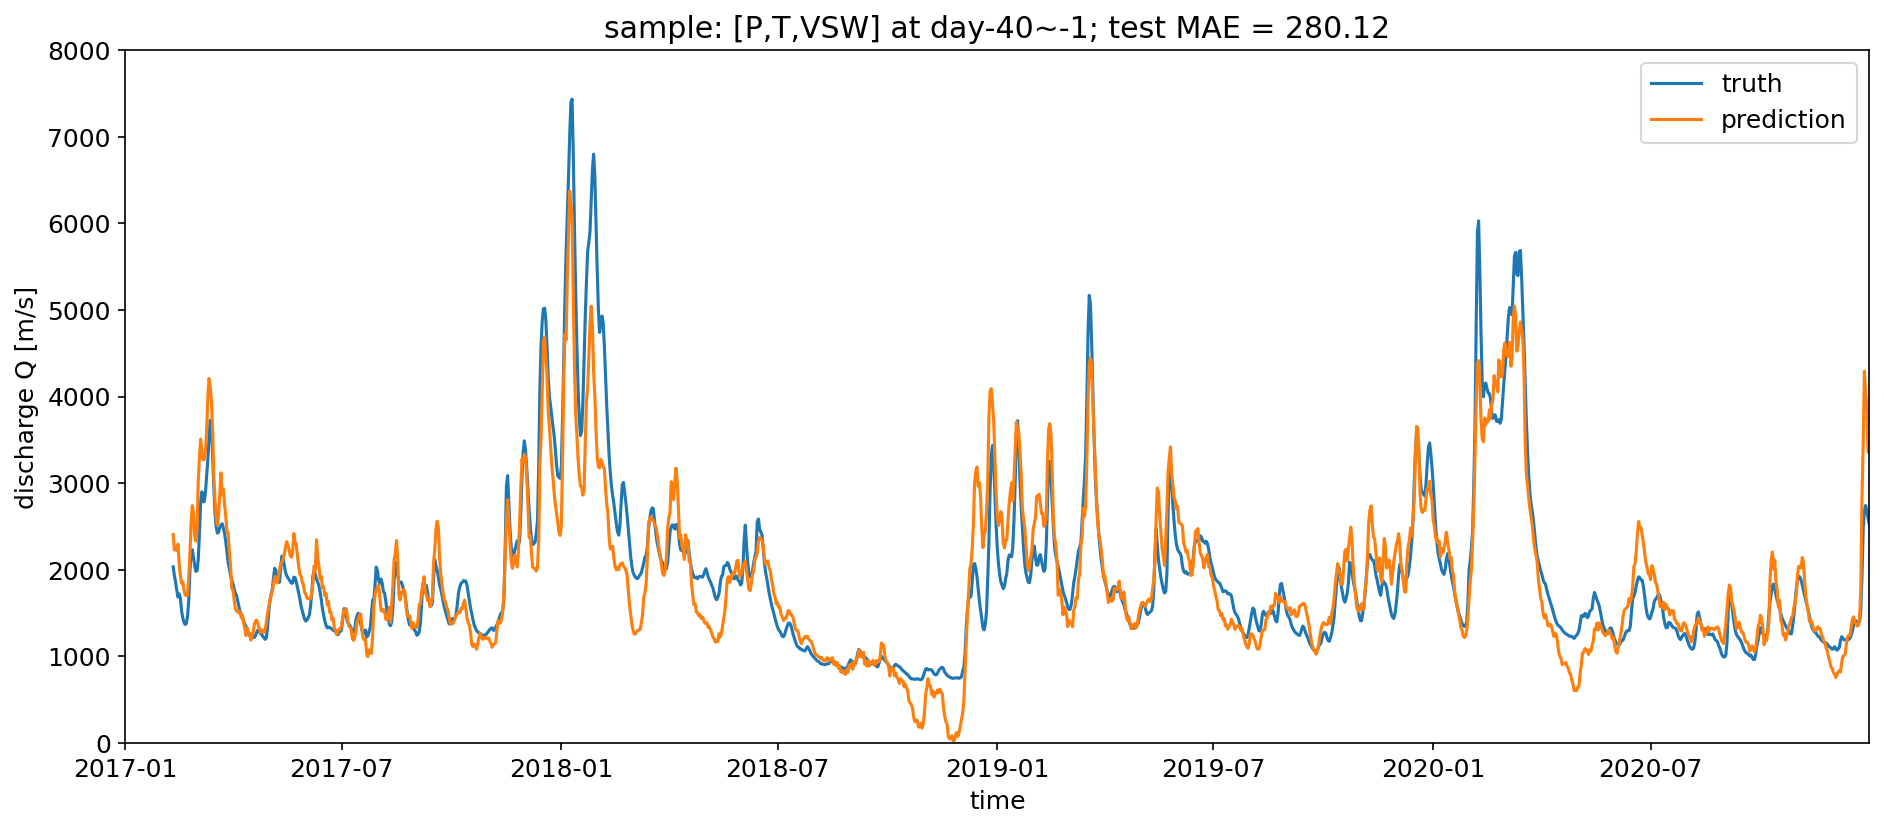

In [190]:
#convert validation data to tensors
X_validation_torch = torch.from_numpy(X_validation_normalized_sliced).float()
labels_validation_torch = torch.from_numpy(labels_validation_sliced).float()
# #define validation custom dataset
# dataset=CustomDataset(X_validation_torch,labels_validation_torch)
# #define validation dataloader
# dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=False)

#this function return predictions and real labels given in input the trained model and a dataloader 
#containing the test data with corresponding labels

def predict(model,X_val):
    # Test the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_val).squeeze()*std_labels+mean_labels
    return predictions

def plt_e(predictions,mae,labels_validation_torch,tt,fname):
    plt.figure(figsize=(15,6))
    plt.plot(time_line_validation_,labels_validation_torch,label='truth')
    plt.plot(time_line_validation_,predictions,label='prediction')
    plt.xlabel('time')
    plt.xlim(datetime(2017,1,1,0,0),datetime(2020,12,31,0,0))
    # plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylabel('discharge Q [m/s]')
    plt.ylim(0,8000)
    plt.legend()
    plt.title('sample: {}; test MAE = {:.2f}'.format(tt,mae))
    plt.savefig("figs/%s_e"%fname, bbox_inches='tight')
    return

maefunc = nn.L1Loss()

predictions_tpv = predict(model_tpv,X_validation_torch)
mae_tpv = maefunc(predictions_tpv,labels_validation_torch)
plt_e(predictions_tpv,mae_tpv,labels_validation_torch,'[P,T,VSW] at day-40~-1','tpv40')
# predictions_tp = predict(model_tp,X_validation_torch)
# mae_tp = maefunc(predictions_tp,labels_validation_torch)
# plt_e(predictions_tp,mae_tp,labels_validation_torch,'[P,T] at day-40~-1','tp40')
# predictions_tpv16 = predict(model_tpv16,X_validation_torch)
# mae_tpv16 = maefunc(predictions_tpv16,labels_validation_torch)
# plt_e(predictions_tpv16,mae_tpv16,labels_validation_torch,'[P,T,VSW] at day-16~-2','tpv16')

# **SHAP** 

In [16]:
# for the full tpv model
# remember to use correct X_validation_torch
# this part takes about 1.5h on my PC, so I saved the results in the npy files
import shap

X_jja_torch = torch.from_numpy(X_jja).float()
X_djf_torch = torch.from_numpy(X_djf).float()

e = shap.DeepExplainer(model_tpv, X_validation_torch)
shap_values_jja = e.shap_values(X_jja_torch)
shap_values_djf = e.shap_values(X_djf_torch)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [45]:
np.save("shap_values_jja.npy", shap_values_jja)
np.save("shap_values_djf.npy", shap_values_djf)
# shap_values_jja = np.load("shap_values_jja.npy")
# shap_values_djf = np.load("shap_values_djf.npy")
# shap_values_djf.shape

In [116]:
def plot_shapley(var,tt):
    
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_global()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines(lw=0.5)
    
    lat = np.arange(46,53+1)
    lon = np.arange(4,12+1)
    x_extent = lon
    y_extent = lat
    ax.set_xticks(x_extent,crs=ccrs.PlateCarree())
    ax.set_yticks(y_extent,crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    # Convert lat/lon to map coordinates
    Lon, Lat = np.meshgrid(lon, lat)

    pm = ax.pcolormesh(Lon, Lat, var, cmap=plt.cm.seismic,vmin=-6e-4,vmax=6e-4)

    # Add a colorbar
    cb = plt.colorbar(pm, label="SHAP value", orientation="vertical")
    
    ax.set_title(r"%s"%tt)
    ax.set_aspect('auto')
    plt.savefig("figs/%s"%tt, bbox_inches='tight')

    return

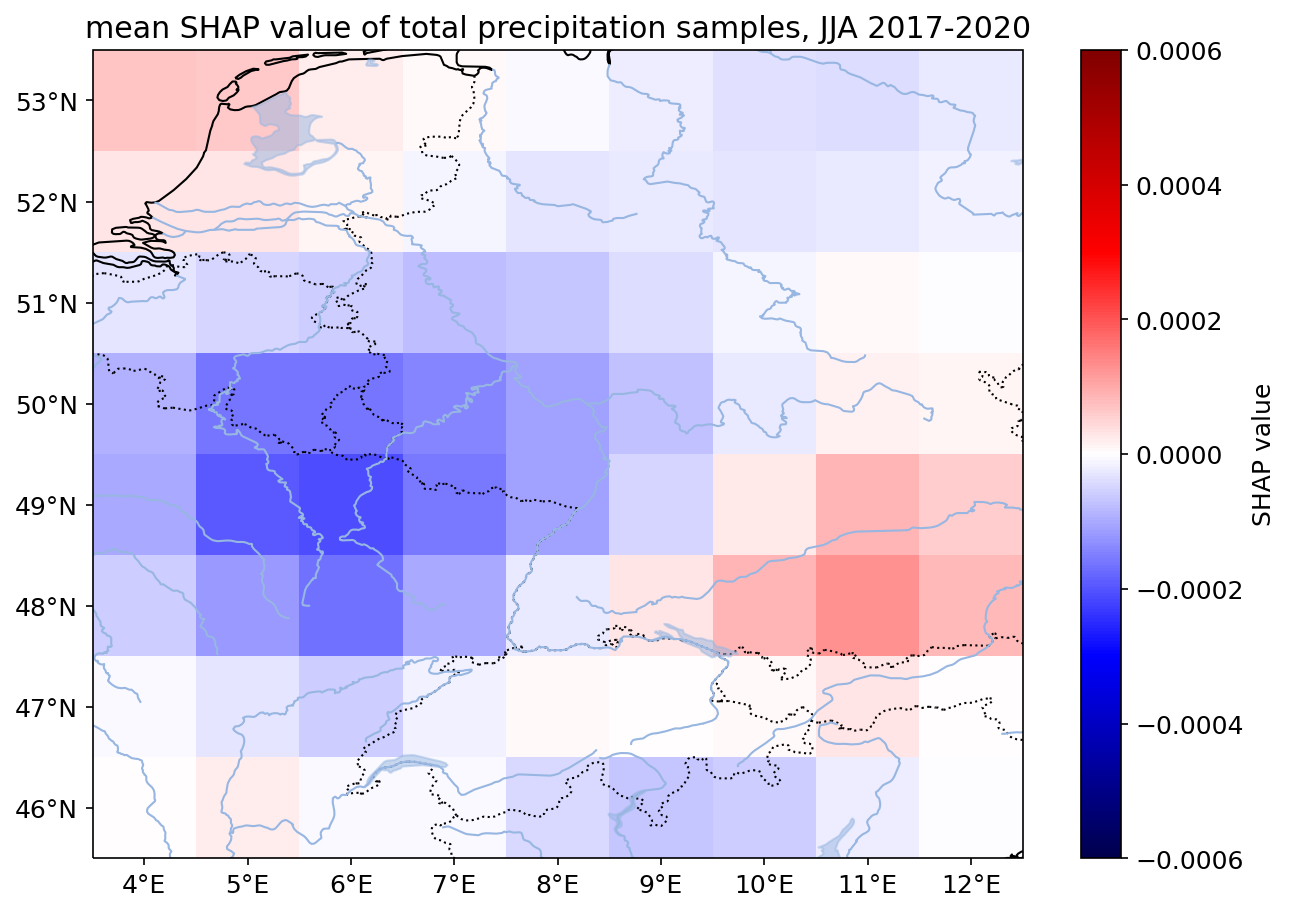

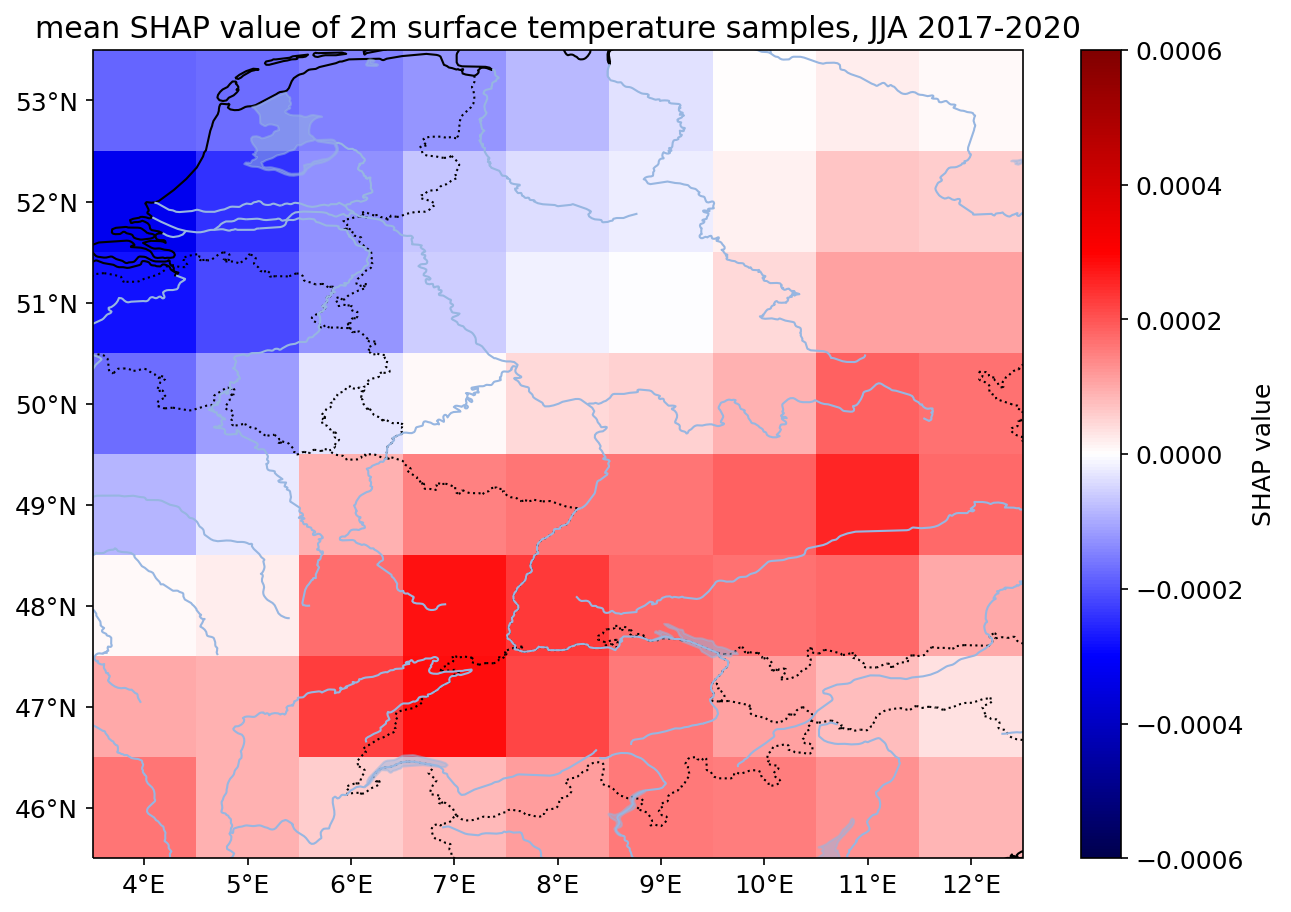

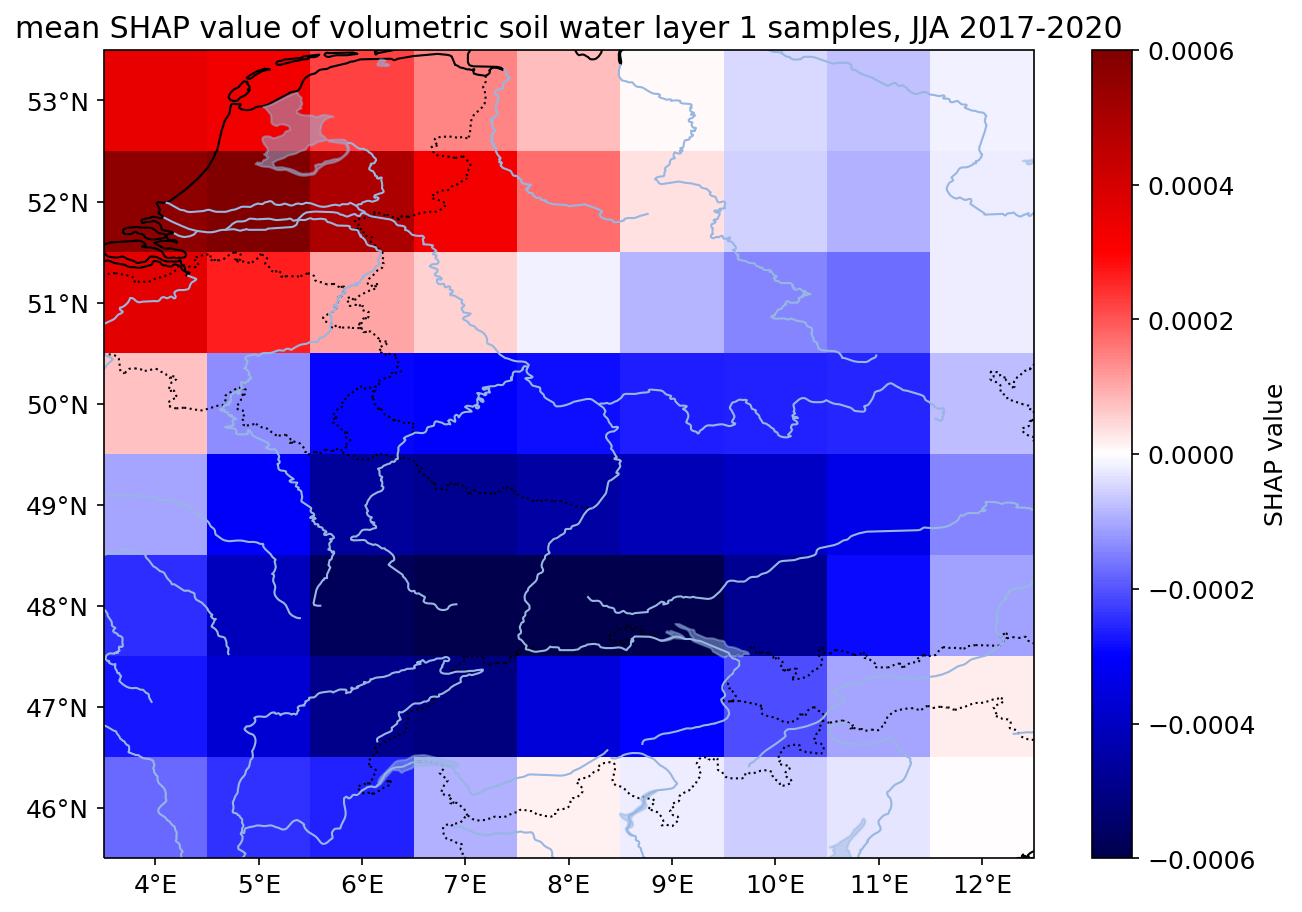

In [117]:
# shap_tp_jja = np.mean(shap_values_jja[:,0,:,:,:],axis=(0,1))
# plot_shapley(shap_tp_jja,'precipitation, JJA 2017-2020')
# shap_tp_jja = np.mean(shap_values_jja[100:200,0,:,:,:],axis=(0,1))
# plot_shapley(shap_tp_jja,'precipitation, JJA 2017-2020')
shap_tp_jja = np.mean(shap_values_jja[:,0,:,:,:],axis=(0,1))
shap_t2m_jja = np.mean(shap_values_jja[:,1,:,:,:],axis=(0,1))
shap_swvl1_jja = np.mean(shap_values_jja[:,2,:,:,:],axis=(0,1))
plot_shapley(shap_tp_jja,'mean SHAP value of total precipitation samples, JJA 2017-2020')
plot_shapley(shap_t2m_jja,'mean SHAP value of 2m surface temperature samples, JJA 2017-2020')
plot_shapley(shap_swvl1_jja,'mean SHAP value of volumetric soil water layer 1 samples, JJA 2017-2020')

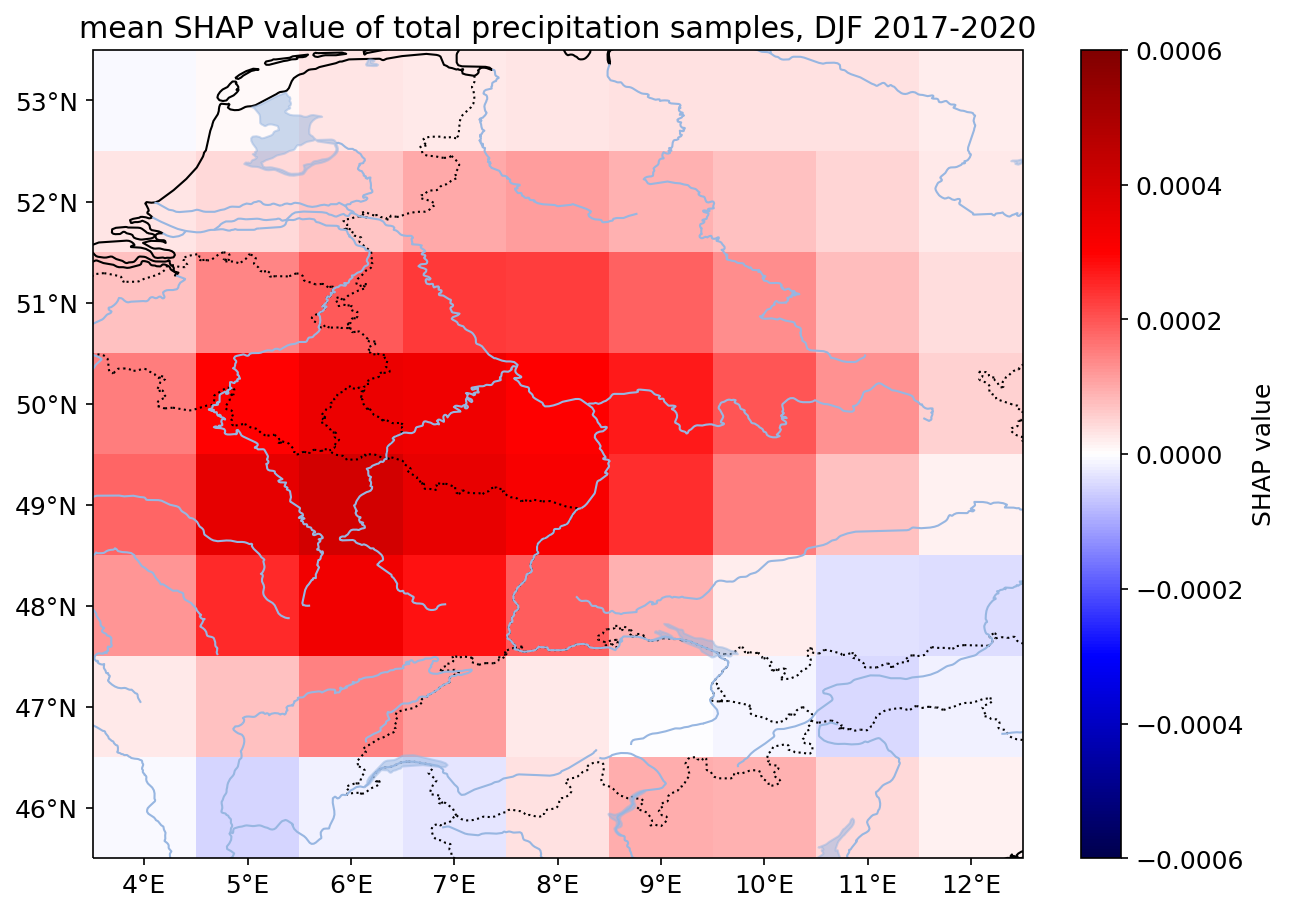

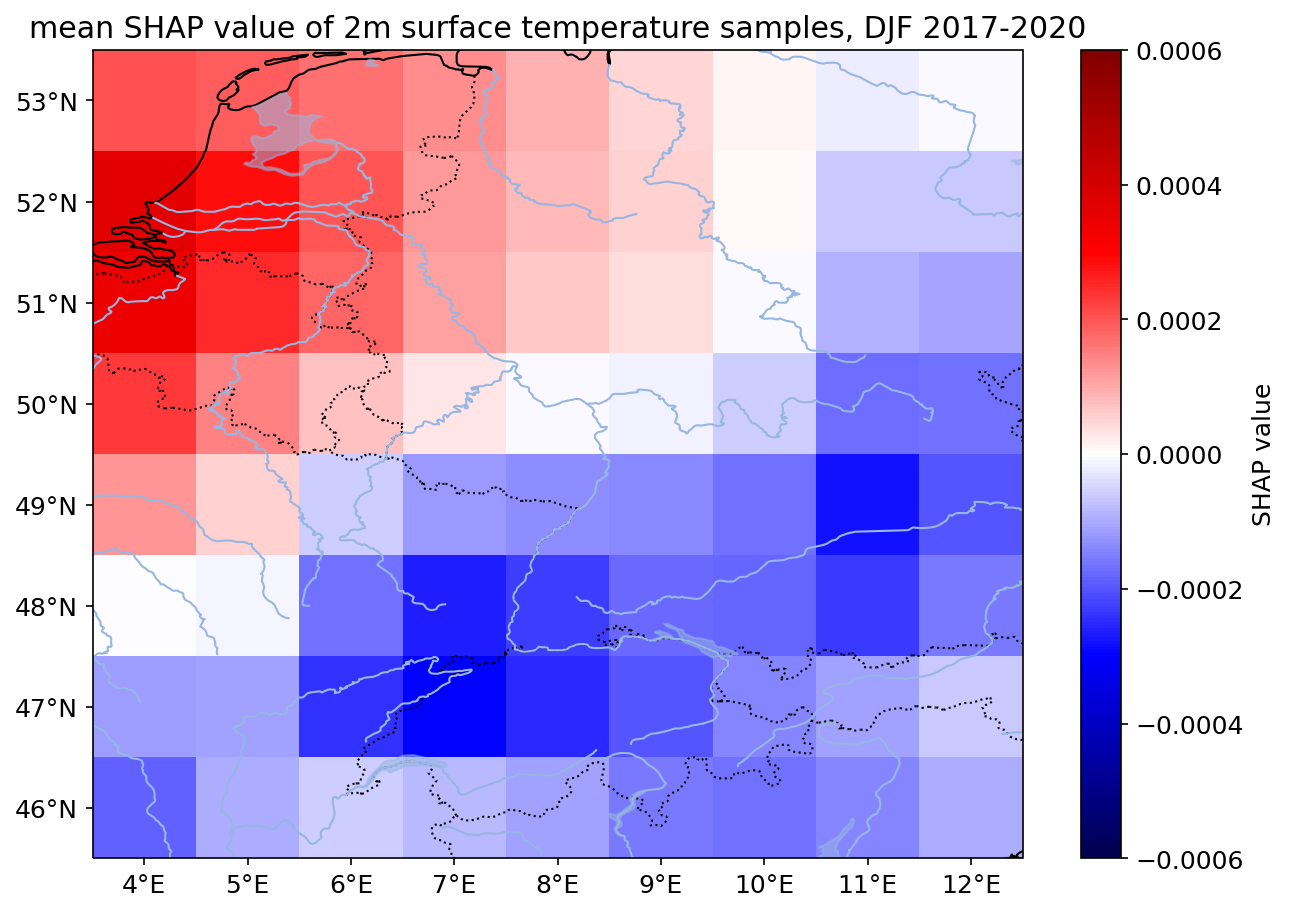

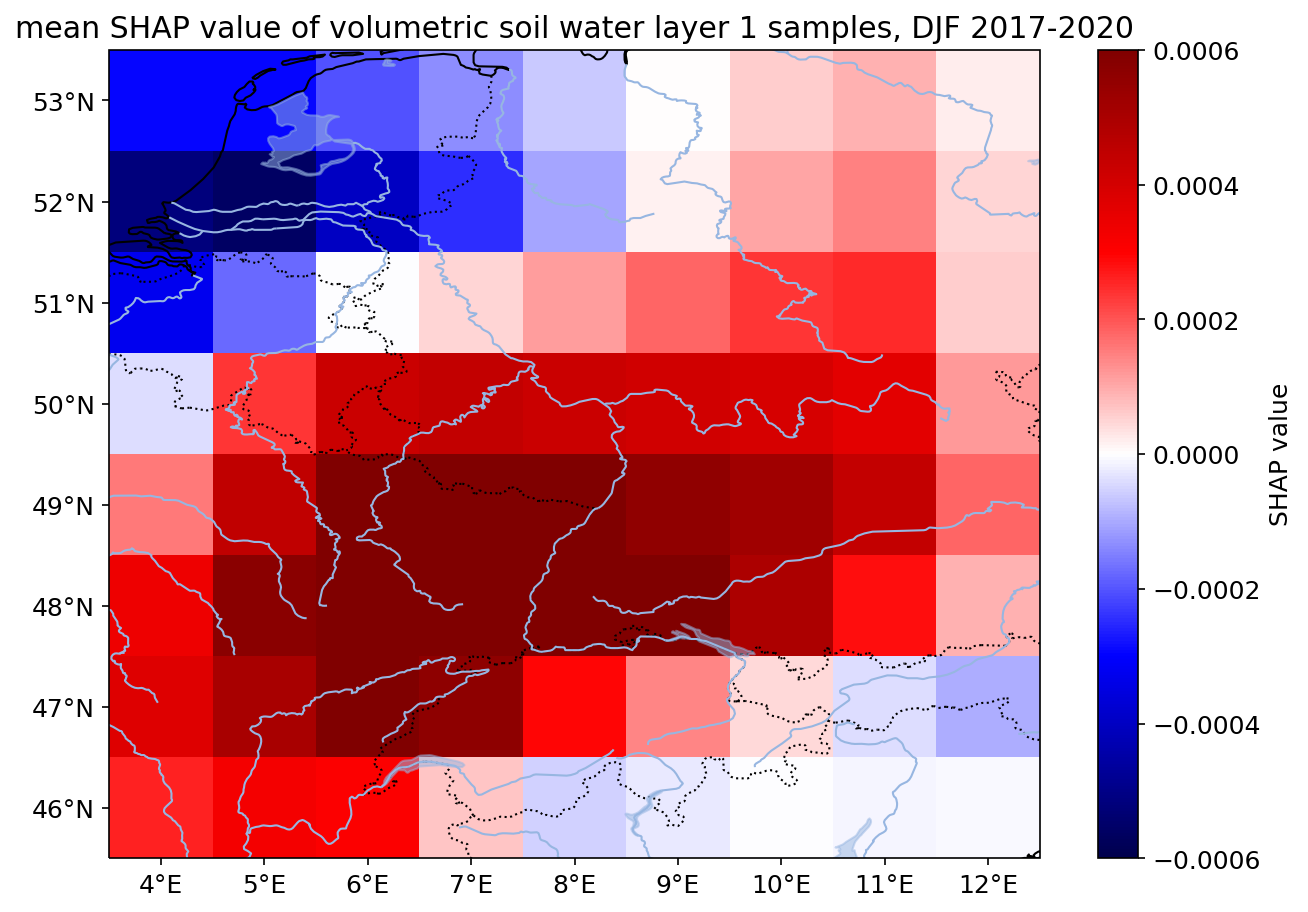

In [118]:
shap_tp_djf = np.mean(shap_values_djf[:,0,:,:,:],axis=(0,1))
shap_t2m_djf = np.mean(shap_values_djf[:,1,:,:,:],axis=(0,1))
shap_swvl1_djf = np.mean(shap_values_djf[:,2,:,:,:],axis=(0,1))
plot_shapley(shap_tp_djf,'mean SHAP value of total precipitation samples, DJF 2017-2020')
plot_shapley(shap_t2m_djf,'mean SHAP value of 2m surface temperature samples, DJF 2017-2020')
plot_shapley(shap_swvl1_djf,'mean SHAP value of volumetric soil water layer 1 samples, DJF 2017-2020')

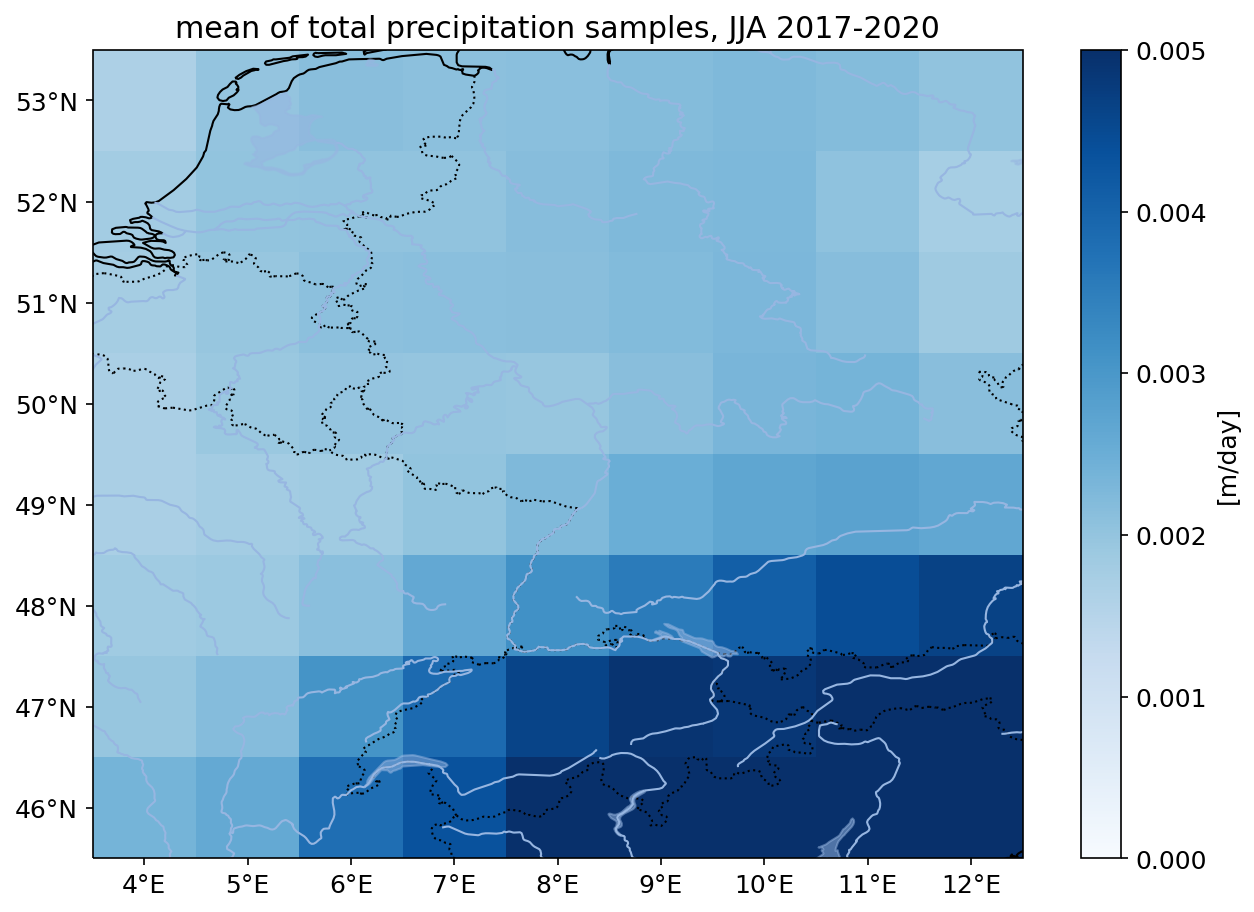

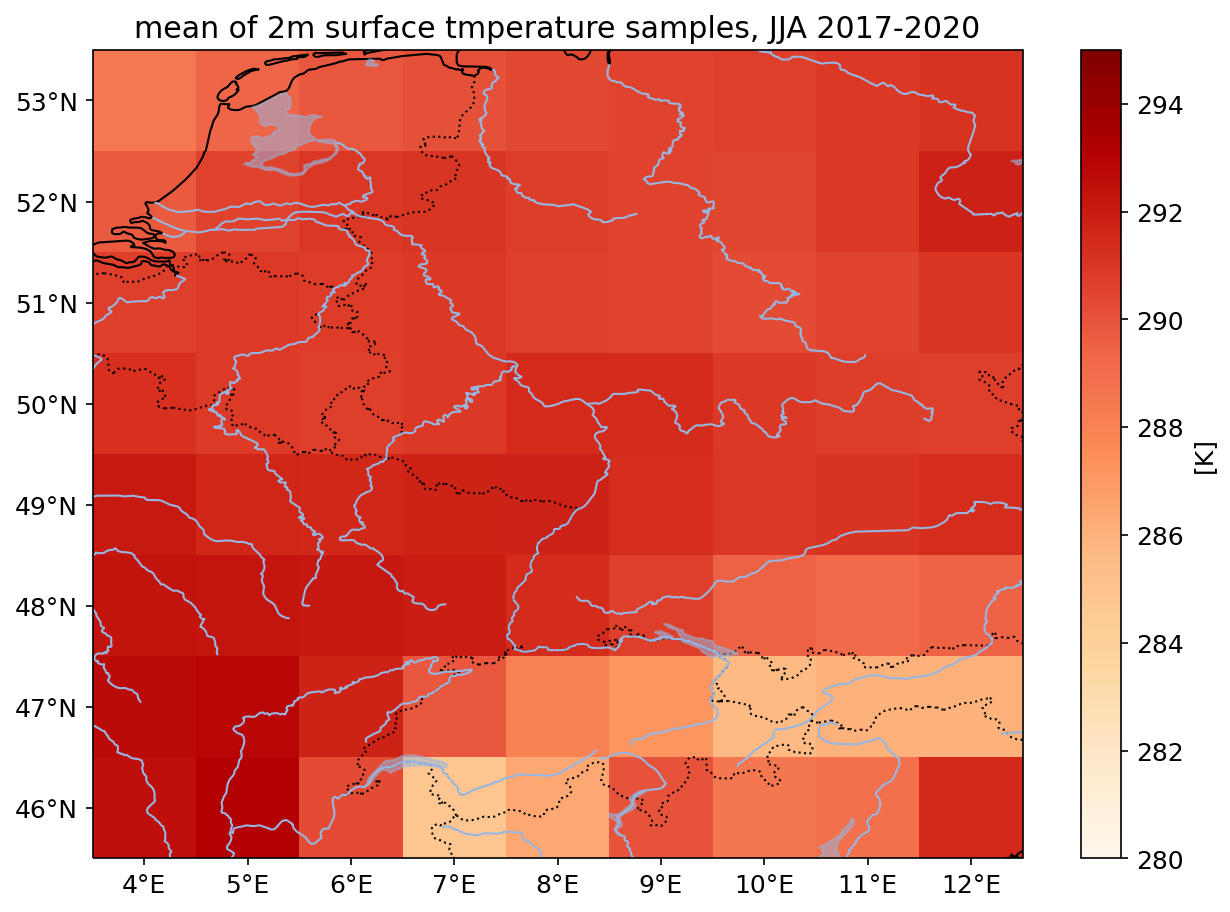

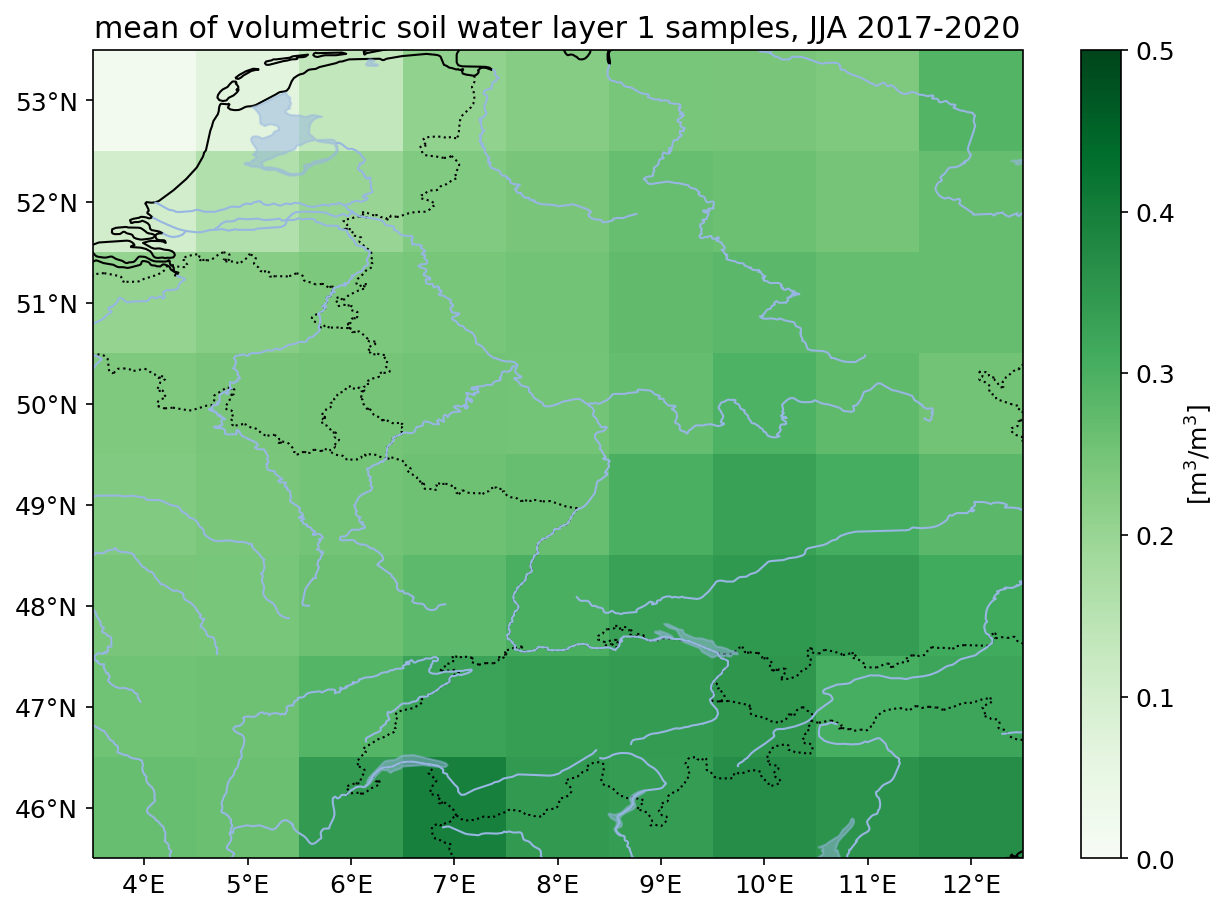

In [115]:
val_jja = X_jja_torch*X_ref_std.reshape((1,3,1,8,9)) + X_ref_mean.reshape((1,3,1,8,9))
tp_val_jja = np.mean(val_jja[:,0,:,:,:].numpy(),axis=1)
t2m_val_jja = np.mean(val_jja[:,1,:,:,:].numpy(),axis=1)
swvl1_val_jja = np.mean(val_jja[:,2,:,:,:].numpy(),axis=1)
plot_monthly_mean(tp_val_jja,'mean of total precipitation samples, JJA 2017-2020','[m/day]',vn=0,vm=5e-3,cmp=plt.cm.Blues)
plot_monthly_mean(t2m_val_jja,'mean of 2m surface tmperature samples, JJA 2017-2020','[K]',vn=280,vm=295,cmp=plt.cm.OrRd)
plot_monthly_mean(swvl1_val_jja,'mean of volumetric soil water layer 1 samples, JJA 2017-2020','[m$^3$/m$^3$]',vn=0,vm=0.5,cmp=plt.cm.Greens)

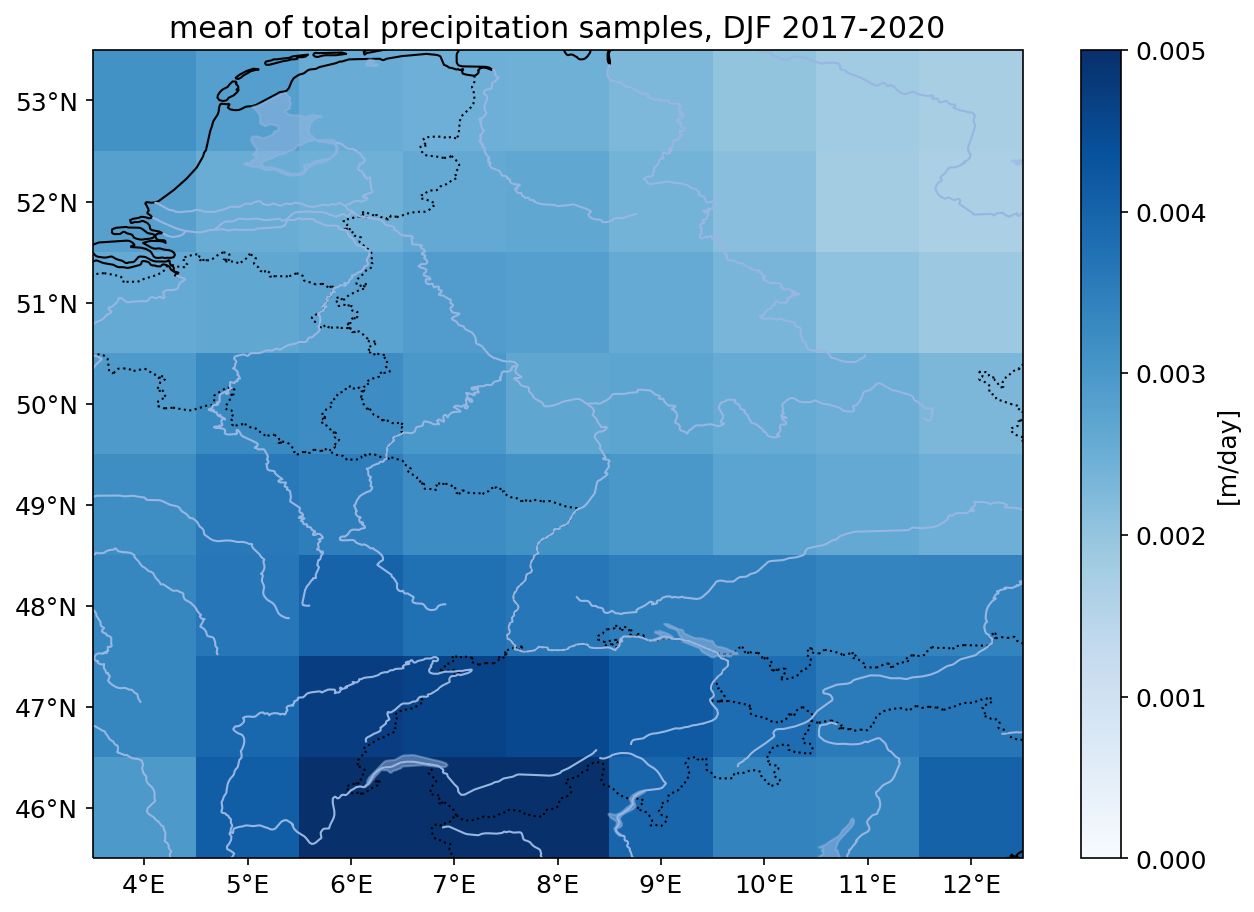

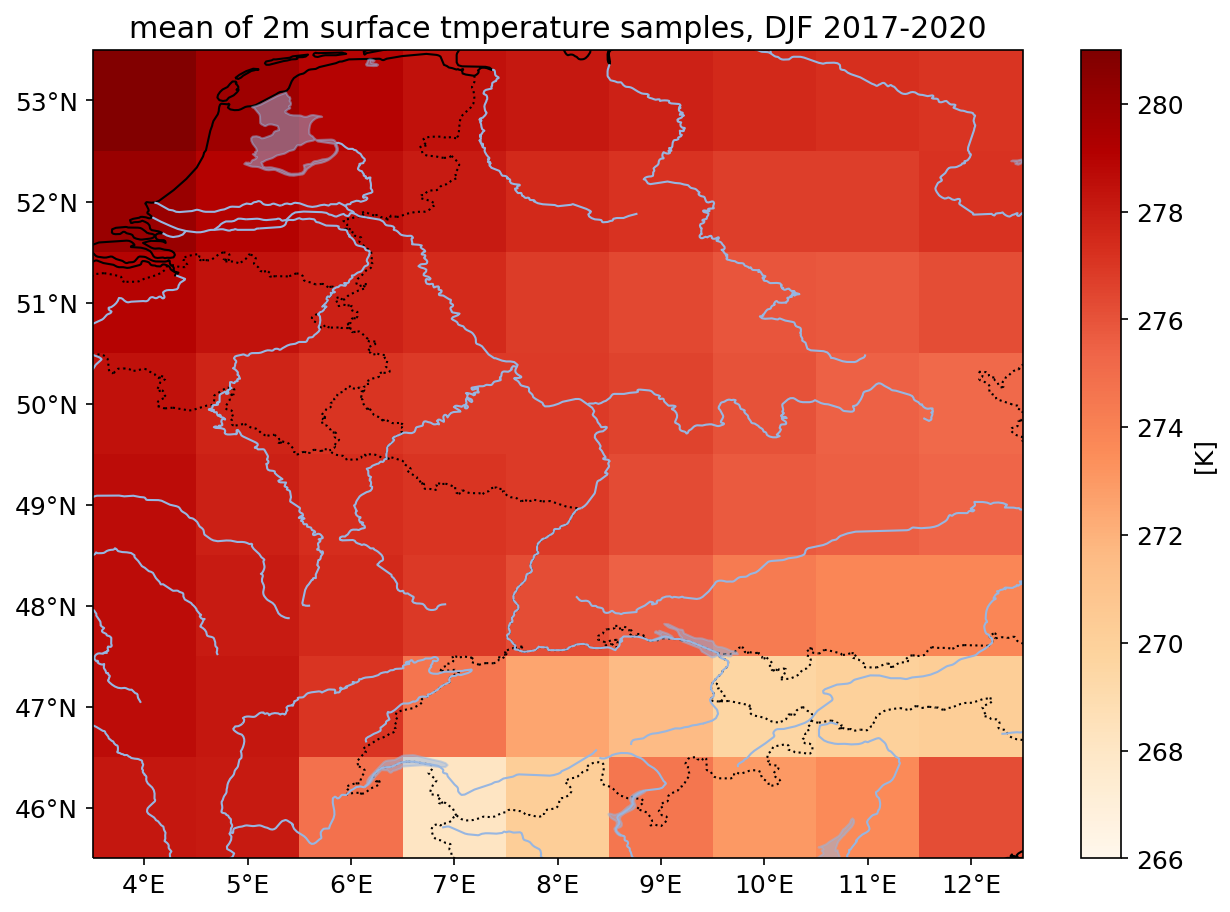

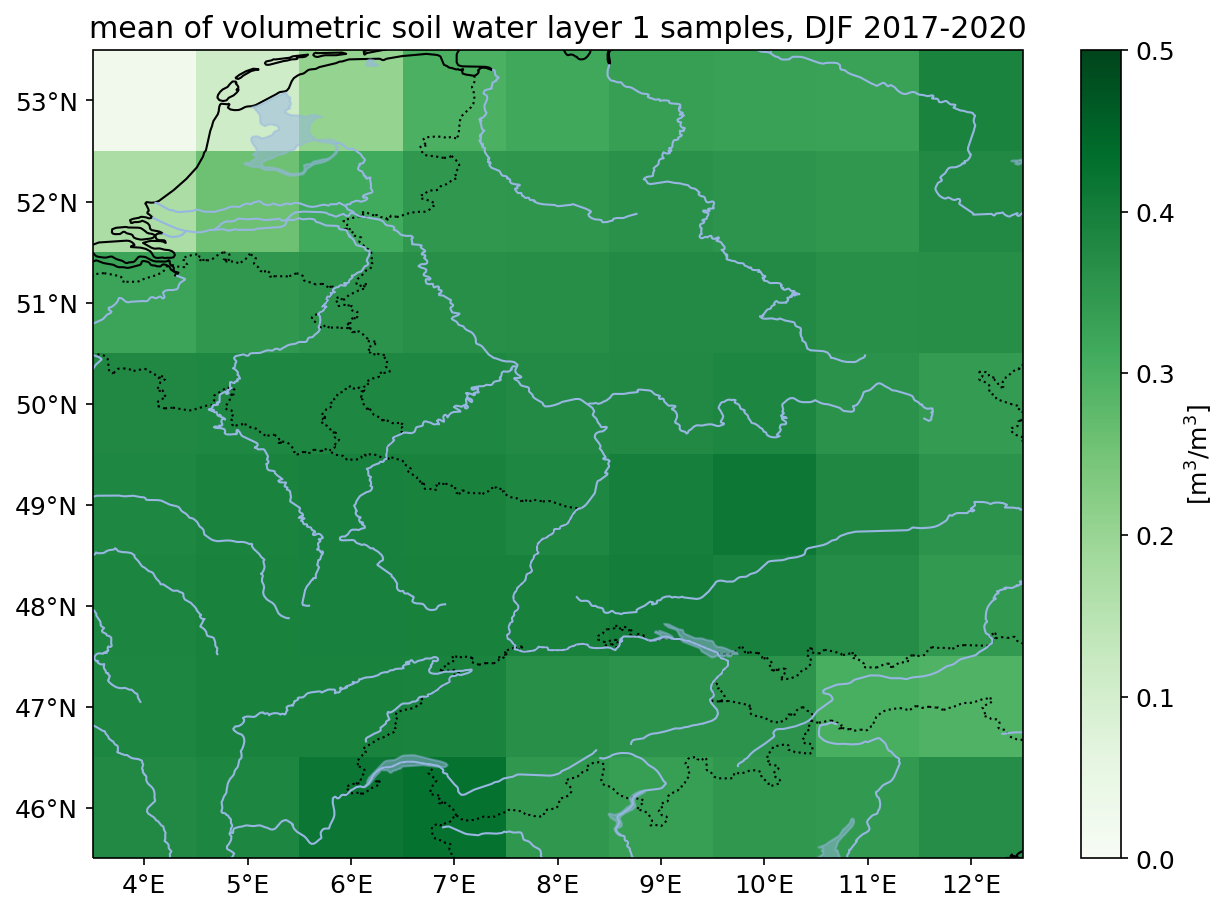

In [112]:
val_djf = X_djf_torch*X_ref_std.reshape((1,3,1,8,9)) + X_ref_mean.reshape((1,3,1,8,9))
tp_val_djf = np.mean(val_djf[:,0,:,:,:].numpy(),axis=1)
t2m_val_djf = np.mean(val_djf[:,1,:,:,:].numpy(),axis=1)
swvl1_val_djf = np.mean(val_djf[:,2,:,:,:].numpy(),axis=1)
plot_monthly_mean(tp_val_djf,'mean of total precipitation samples, DJF 2017-2020','[m/day]',vn=0,vm=5e-3,cmp=plt.cm.Blues)
plot_monthly_mean(t2m_val_djf,'mean of 2m surface tmperature samples, DJF 2017-2020','[K]',vn=266,vm=281,cmp=plt.cm.OrRd)
plot_monthly_mean(swvl1_val_djf,'mean of volumetric soil water layer 1 samples, DJF 2017-2020','[m$^3$/m$^3$]',vn=0,vm=0.5,cmp=plt.cm.Greens)